This file is courtesy of Ricardo Sandoval and is licensed under an MIT license as follows:

```
Copyright 2024 Ricardo J. Sandoval

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```


# SIPP 2014 panel data cleaning and preprocessing

In this notebook, we're loading and preprocessing data from the SIPP dataset. We're trying to get it as close as we can to the the Poverty Tracker dataset. In other words, we're going to try to map the variables not related to shocks from the Poverty Tracker dataset to those in the SIPP dataset.

In [1]:
import re
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt

%matplotlib inline

# Import the raw data

In [2]:
# the variables we're interested in
opm_variables = {
    # 'OPM': , # this could be built using the household income-to-poverty ratio
    'OPMTHRESH': 'rhpov', # household poverty threshold in this month, excluding Type 2 individuals
    'OPM_RATIO': 'thcyincpov'# household income-to-poverty ratio in this calendar year
}

hardship_variables = {
    'LIVING_QUARTERS_TYPE': 'tlivqtr', # type of living quarters
    'LIVING_OWNERSHIP': 'etenure', # are ... living quarters owned, rented, or occupied without payment of rent?
    'ENERGY_ASSISTANCE': 'eenergy_asst', # did household receive any energy assistance from the governemnt at any
    # time during the reference year?
    
    # could combine the four variables below into one
    'FOOD_VOUCHERS': 'efood_type1', # did ... recieve money, vouchers, or certificates to buy groceries or food?
    'FOOD_BAGS': 'efood_type2', # did ... recieve bags of groceries or packaged foods?
    'FOOD_CHARITY': 'efood_type3', # did ... recieve assistance from a shelter, soup kitchecn, Meals-on-wheels, or
    # other charity?
    'FOOD_OTH_HELP': 'efood_oth', # did ... receive some other kind of food assistance?
    
    # change this into separate variables saying what percentage of the year respondents were covered
    'SNAP_BMONTH': 'efs_bmonth', # when did SNAP start?
    'SNAP_EMONTH': 'efs_emonth', # when did SNAP end?
    'WIC_BMONTH': 'ewic_bmonth', # begin month of WIC spell
    'WIC_EMONTH': 'ewic_emonth', # end month of WIC spell
    
    'HOUSE_PAY_ASSISTANCE': 'ehouse_any', # did ... receive assistance to help pay for housing?
}

health_variables = {
    'MEDICARE_D_PAY': 'tsspartdpd', # how much did ... pay for his/her Medicare Part D coverage?
    # change this into separate variables saying what percentage of the year respondents were covered
    'MEDICARE_BMONTH': 'emc_bmonth', # begin month of Medicare spell
    'MEDICARE_EMONTH': 'emc_emonth', # end month of Medicare spell
    'MEDICAID_BMONTH': 'emd_bmonth', # begin month of Medicaid spell
    'MEDICAID_EMONTH': 'emd_emonth', # end month of Medicaid spell
    
    'HEALTHDISAB': 'edisabl', # does ... have a physical, mental or other health condition that limits the kind or
    # amount of work he/she can do?
    'DAYS_SICK': 'tdaysick', # how many days did illness or injury keep ... in bed more than half of the day?
    'HOSPITAL_NIGHTS': 'thospnit', # how many nights did ... spend in the hospital
    'PRESCRIPTION_MEDS': 'epresdrg', # did ... take any prescription medications?
    'VISIT_DENTIST': 'tvisdent', # how many visits has ... made to a dentist or other dental professional?
    'VISIT_DOCTOR': 'tvisdoc', # how many times did ... see or talk to a doctor, nurse, or any other type of medical
    # provider about his/her health?
    'HEALTH_INSURANCE_PREMIUMS': 'thipay', # how much did ... pay for comprehensive health insurance premiums
    'HEALTH_OVER_THE_COUNTER_PRODUCTS_PAY': 'totcmdpay', # how much did ...  pay for his/her non-premium medical
    # out-of-pocker expenditures for over-the-counter health-related products?
    'HEALTH_MEDICAL_CARE_PAY': 'tmdpay', # how much did ... pay for his/her non-premium medical out-of-pocket
    # expenditures on medical care
    'HEALTH_FLEX_SPENDING_ACC': 'eflexspnd', # does ... have a Flexible Spending account for health expenses?
    'NO_INSUR_DENTIST': 'enoindnt', # during the month(s) ... was not covered by any health insurance, did he/she
    # go to a dentist or other dental professional?
    'NO_INSUR_DOC': 'enoindoc', # during the month(s) ... was not covered by any health insurance, did he/she go
    # to a doctor, nurse, or other medical provider?
    'HEALTH_HELP_CLINIC': 'enoincln', # ... recieved health care service sin clinic or public health department
    'HEALTH_HELP_ER': 'enoiner', # ... received health care services in ER
    'HEALTH_HELP_HSP': 'enoinhsp', # ... received health care services in hospital (excluding ER)
    'HEALTH_HELP_VA': 'enoinva', # ... received health care services in VA hospital
    'HELATH_HELP_DR': 'enoindr', # ... received health care service in Doctor's office
    'HEALTH_HELP_DENTIST': 'enoindds', # ... received health care service in Dentist's office
    'HEALTH_HELP_OTH': 'enoinoth', # ... received health care serive somplace else
    'HEALTH_ILLNESS_OR_INJURY': 'enointrt', # ... received a treatment for an illness or injury
    'HEALTH_PREVENTATIVE': 'enoinchk', # ... received any routine or preventative care
    'HEALTH_HEARING': 'ehearing', # is ... deaf or does he/she have serious difficulty hearing?
    'HEALTH_SEEING': 'eseeing', # is ... blind or does he/she have serious difficulty seeing?
    'HEALTH_COGNITIVE': 'ecognit', # does ... have serious difficulty concentrating, remembering, or making decisions?
    'HEALTH_AMBULATORY': 'eambulat', # does ... have serious difficulty walking or climbing stairs?
    'HEALTH_SELF_CARE': 'eselfcare', # does ... have difficulty dressing or bathing?
    'HEALTH_ERRANDS_DIFFICULTY': 'eerrands', # does ... have difficulty doing errands alone?
    'HEALTH_FIND_JOB_DIFFICULTY': 'efindjob', # does ... have difficulty finding a job or remaining employed?
    'HEALTH_JOB_DIFFICULTY': 'ejobcant', # is ... prevented from working?
    'HEALTH_DEVELOPMENT_DELAY': 'eddelay', # does ... have a serious physical or mental condition or a developmental
    # delay that limits ordinary activity?
    'HEALTH_CORE_DISABILITY': 'rdis', # indicates individual has at least one of six core disability measures
    'HEALTH_SUPPLEMENTAL_DISABILITY': 'rdis_alt', # indicates individual has at least one of six core disability
    # measures
    'EMPLOYER_HEALTH_INSURANCE': 'eempnoesi', # whether employer offered health insurance to any of its employees
}

demographics_variables = {
    'AGE': 'tage', # age as of last birthday
    'GENDER': 'esex',
#    'RACE': 'erace', # note, this is much less detailed than `TRACE`
    'RACE': 'trace', # note, this is much less detailed than `TRACE`    
    'EDUCATION': 'eeduc',
    'MARITAL_STATUS': 'ems', # is ... currently married, widowed, divorced, separated, or never married?
    'CITIZENSHIP_STATUS': 'ecitizen', # is ... a citizen of the United States
    'FAMILY_SIZE': 'rfpersons', # number of persons in the family
    'NUM_VEHICLES': 'tveh_num', # number of cars, trucks, or vans owned by the household during the reference period
    'ORIGIN' : 'eorigin', #Is ... Spanish, Hispanic, or Latino?
}

income_variables = {
    'HOUSEHOLD_INC': 'thtotinc', # sum of all earnings and income received by a household, from all household
    # members age 15 and older for each month of the reference year
    
    # combine the next three into one variable
    'ASSISTANCE_INC': 'tptrninc', # the sum of the reported monthly amounts recieved by an individualfrom TANF
    # SSI, Pass-through child support payments, General Assistance, or general relief
    'WORKER_COMP_INC': 'tpscininc', # the sum of the reported monthly amounts received by an individual from 
    # VA benefits (except VA pension), workers' compensation, unemployment compensation, or social security
    'OTH_INC': 'tpothinc', # a monthly income recode variable, which is the sum of the reported monthly amounts
    # received by an individual from other income sources, such as: survivor benefits, retirement benefits, disability
    # benefits, foster child care payments, child support payments, alimony payments, lump sum payments, deferred 
    # payments from prior job, life insurance payments, or miscellaneous income sources
    
    # combine the next two into one
    'INVESTMENT_INC': 'tpprpinc', # the amount of total personal investment and property income during the reference
    # year
    'INDIVIDUAL_TOTAL_INC': 'tptotinc', # the sum of reported monthly earnings and income amounts recieved by an 
    # individual during the refernece year
    
    # combine the next two into one variable
    'IRA_AMOUNT': 'tirakeoval', # value of IRA and KEOGH accounts as of hte last day of the reference period
    'AMOUNT_401': 'tthr401val', # value of 401k, 403b, 503b, and Thrift Savings Plan accounts as of the last day of
    # the reference period
    
    'RECEIVED_WORK_COMP': 'ewc_any', # did ... receive worker's compensation payments at any time during the
    # reference period?
}

identifier_variables = {
    'SSUID': 'ssuid',
    'PNUM': 'pnum'
}

other_assistance_variables = {
    # turn into one variable that encodes percentage of year being covered
    'TANF_BMONTH': 'etanf_bmonth', # begin month of TANF spell
    'TANF_EMONTH': 'etanf_emonth', # end month of TANF spell
    
    # combine into one variable that tells whether received assistance with transportation
    'GAS_VOUCHERS': 'etrans_type1', # did ... receive gas vouchers?
    'PUBLIC_TRANSIT_PASSES': 'etrans_type2', # did ... receive bus or subway tokens or passes?
    'CAR_HELP': 'etrans_type3', # did ... receive help registering, repairing, or insuring a car?
    'RIDE_TO_DOCTOR': 'etrans_type4', # did ... receive ride to a doctor's office or medical appointment
    'OTH_TRANSPORTATION_ASSISTANCE': 'etrans_oth', # did ... receive some other kind of transportation assistnace

    'UNEMPLOYMENT_COMP': 'eucany', # did ... receive unemployment compensation payments at any time during the 
    # reference period?
    
    # combine the three into one variable
    'GOVT_UNEMPLOYMENT_COMP': 'tuc1amt', # amount of regular, governemtn-provided unemployment compensation payments
    # received in each month of the reference period
    'EMPLOYER_UNEMPLOYMENT_COMP': 'tuc2amt', # amount of supplemental employer-provided unemployment compensation
    # payments received ine ach month of reference period
    'OTH_UNEMPLOYMENT_COMP': 'tuc3amt', # amount of other unemployment compensation payments, including union benefits
    # received in each month of reference period
    
    'VA_BENEFIT_PAYMENTS': 'evaany', # did ... receive any benefit payments from the department of venteans affairs
    # at any time during the reference period
    
    # combine the next fixe into one variable
    'VA_BENEFITS_DISABILITY': 'tva1amt', # how much did ... receive in VA benefits from a service connected 
    # disability this month?
    'VA_BENEFITS_PENSION': 'tva2amt', # how much did ... receive in VA benefits from a veternas' pension this month?
    'VA_BENEFITS_OTH': 'tva3amt', # how much did ... receive in VA benefit payments from other VA programs this month?
    'VA_BENEFITS_GI': 'tva4amt', # how much did ... receive in VA benefit payments from G.I. bill benefits this month?
    'VA_BENEFITS_INSURANCE': 'tva5amt', # how much did ... receive in VA benefit payments from insurance proceeds
    # this month?
    
    # combine the next two into one variable
    'SOC_SEC_BENEF_SELF': 'esssany', # did ... receive social security benefits for himself/herself at any time during
    # the reference period?
    'SOC_SEC_BENEF_CHILD': 'esscany', # did ... receive any social security benefit at any time during the reference
    # period on behalf of a child(ren)?
    
    'CHILD_CARE_PAY_ASST': 'epayhelp', # did reference parent receive assistance to pay for child care?
    
    # combine next 8 into one variable
    'RETIR_INCOME_PENSION': 'tret1amt', # how much retirement income did … receive from a pension from a company 
    # or union including income from a profit sharing plan this month?
    'RETIR_INCOME_FEDERAL_SERVICE': 'tret2amt', # how much retirement income did … receive from a Federal 
    # civil service or other Federal civilian employee pension this month?
    'RETIR_INCOME_STATE_GOVT': 'tret3amt', # how much retirement income did … receive from a State government 
    # pension this month?
    'RETIR_INCOME_LOCAL_GOVT': 'tret4amt', # how much retirement income did … receive from a local government 
    # person this month?
    'RETIR_INCOME_MILITARY': 'tret5amt', # how much retirement income did … receive from a Military retirement 
    # pay this month?
    'RETIR_INCOME_RAILROAD': 'tret6amt', # how much retirement income did … receive from a U.S. 
    # Government railroad retirement this month?
    'RETIR_INCOME_NATIONAL_GUARD': 'tret7amt', # how much retirement income did … receive from a National 
    # Guard or reserve forces retirement this month?
    'RETIR_INCOME_OTH': 'tret8amt', # how much retirement income did … receive from other retirement income 
    # this month?
    
    # combine the next variables into one
    'SURVIVOR_INC_PENSION': 'tsur1amt', # how much survivor income did … receive in pension from a 
    # company or union including income from a profit-sharing plan during this month?
    'SURVIVOR_INC_VETERAN': 'tsur2amt', # how much survivor income did … receive from Veteran’s 
    # compensation during this month?
    'SURVIVOR_INC_FEDERAL': 'tsur3amt', # how much survivor income did … receive form the 
    # Federal Civil Service or other Federal civilian employee pension during this month?
    'SURVIVOR_INC_RAILROAD': 'tsur4amt', # how much survivor income did … receive from the 
    # U.S. Governemnt Railroad retirement during this month?
    'SURVIVOR_INC_STATE_GOVT': 'tsur5amt', # how much survivor income did … receive from a 
    # state government during this month?
    'SURVIVOR_INC_LOCAL_GOVT': 'tsur6amt', # how much survivor income did … receive from a 
    # local government pension during this month?
    'SURVIVOR_INC_LIFE_INSUR': 'tsur7amt', # how much survivor income did … receive from a 
    # paid-up life insurance policy or annuity during this month?
    'SURVIVOR_INC_MILITARY': 'tsur8amt', # how much survivor income did … receive from military 
    # retirement pay during this month?
    'SURVIVOR_INC_ESTATE': 'tsur11amt', # how much survivor income did … receive from an estate 
    # or trust during this month?
    'SURVIVOR_INC_OTH': 'tsur13amt', # how much other survivor income did … receive during this month?

    # combine the next variables into one
    'DISABILITY_PAY_INSURANCE': 'tdis1amt', # how much did … receive in payments from a sickness, accident, 
    # or disability insurance policy this month?
    'DISABILITY_PAY_EMPLOYER': 'tdis2amt', # how much did … receive in employer disability payments this month?
    'DISABILITY_PAY_PENSION': 'tdis3amt', # how much did … receive in disability income from a pension from a company 
    # or union including from a profit-sharing plan this month?
    'DISABILIITY_PAY_FEDERAL': 'tdis4amt', # how much did … receive in Federal civil service or other federal 
    # civilian employee pension this month?
    'DISABILITY_PAY_STATE': 'tdis5amt', # how much did … receive in disability income from a state government 
    # pension this month?
    'DISABILITY_PAY_LOCAL': 'tdis6amt', #  how much did … receive in disability income from a local government 
    # pension this month?
    'DISABILITY_PAY_MILITARY': 'tdis7amt', # how much did … receive in disability income from a military retirement 
    # person this month?
    'DISABILITY_PAY_OTH': 'tdis10amt', # how much did … receive in other disability income this month?
    
    'EVER_RETIRE': 'eeveret', # did ... ever retire for any reason from a job or business?
    'SEVERANCE_PAY_PENSION': 'elmpnow', # did … receive any severance pay or lump sum payments from a pension 
    # or retirement plan during the reference period?
    'TOTAL_PENSION_LUMP_SUMP_PAY': 'tlmpamt', # what was the total amount of lump sum payments … received during 
    # the reference period from a pension or retirement plan, or severance pay, or some other type of lump sum 
    # payment?
    'INVEST_ROLL_OVER': 'erollovr1', # did … re-invest or roll over the lump sum payment into an IRA or other 
    # retirement plan?
    'PLAN_INVEST_ROLL_OVER': 'erollovr2', # does … plan on re-inventing or rolling over any of the lump sum 
    # payment into an IRA or other retirement plan?
    'ROLL_OVER_AMT': 'trollamt', # how much did … roll over or plan to roll over into another retirement account?
    'DEFERRED_INC_AMT': 'tdeferamt', # what was the total amount of deferred income or final pay-check received?
    'TOTAL_LIFE_INSURANCE_AMT': 'tlifeamt', # what was the total amount of life insurance payments … received?
    'FOSTER_CHILD_CARE_AMT': 'tfccamt', # amount of foster child care payments received in each month of reference 
    # period.
    'CHILD_SUPPORT_AMT': 'tcsamt', # amount of child support payments in each month of reference period.
    'ALIMONY_AMT': 'taliamt', # amount of alimony payments received in each month of reference period
}

In [3]:
# create a list of the dictionaries of the different variables in order to make it easier to extract them
variables_dicts_list = [identifier_variables, opm_variables, hardship_variables, health_variables, 
                        demographics_variables, income_variables, other_assistance_variables]

# create two lists, one with the original SIPP variable names and another one with the names I'll be assigning them
sipp_variables_names = [list(vars_dict.values()) for vars_dict in variables_dicts_list]
sipp_variables_names = list(chain.from_iterable(sipp_variables_names))

my_variables_names = [chain.from_iterable(list(vars_dict.keys())) for vars_dict in variables_dicts_list]
my_variables_names = list(chain.from_iterable(my_variables_names))

In [4]:
PATH_TO_RAW_DATA = ''

OBTAIN THESE FILES FROM THE US CENSUS WEB SITE

In [5]:
raw_data = {
    'wave_1': pd.read_stata(PATH_TO_RAW_DATA + 'pu2014w1_v13.dta', columns=sipp_variables_names, preserve_dtypes=True),
    'wave_2': pd.read_stata(PATH_TO_RAW_DATA + 'pu2014w2_v13.dta', columns=sipp_variables_names, preserve_dtypes=True)
}

# Utils

In [6]:
def determine_uniqueness_of_column(df, variable_name, exclude_nan=True, print_same_throughout_info=True,
                                   return_variating_variable_name=False):
    """
    Determine whether all the entries (for each respondent) for a variable are the same.
    """
    same_throughout = True
    for index, data in df[variable_name].iterrows():
        if exclude_nan:
            data_copy = data.dropna()
        else:
            data_copy = data.copy()
            
        if len(data_copy.unique()) > 1:
            print(f"Values in `{variable_name}` ARE NOT the same throughout.")
            same_throughout = False
            break
    
    if same_throughout and print_same_throughout_info:
        print(f"Values in `{variable_name}` ARE the same throghout.")
    
    if return_variating_variable_name and not same_throughout:
        return variable_name

# Data pre-processing

In [7]:
preprocessed_data = dict()

## Create a unique ID for each individual

According to the SIPP documentation for the 2014 panel, each person can be uniquely identified by the combination of <code>ssuid</code> and <code>pnum</code>. Hence, we'll be creatin the <code>UNIQUE_ID</code> by concatenating <code>ssuid</code> + <code>pnum</code>.

In [8]:
def create_unique_id(df):
    """
    Create a new dataframe that contains the `UNIQUE_ID` column.
    """
    df_copy = df.copy()
    
    # convert the pnum column from an int to a string
    df_copy['pnum'] = df_copy['pnum'].astype('str')
    
    # create the `UNIQUE_ID` column
    df_copy['UNIQUE_ID'] = df_copy['ssuid'] + df_copy['pnum']
    
    return df_copy

In [9]:
preprocessed_data['wave_1'] = create_unique_id(raw_data['wave_1'])
preprocessed_data['wave_2'] = create_unique_id(raw_data['wave_2'])

In [10]:
print(f"There are {len(preprocessed_data['wave_1']['UNIQUE_ID'].unique())} unique individuals in wave 1.")
print(f"There are {len(preprocessed_data['wave_2']['UNIQUE_ID'].unique())} unique individuals in wave 2.")

There are 72919 unique individuals in wave 1.
There are 57570 unique individuals in wave 2.


## Reshape the dataframes

The way the SIPP data is stored is that each respondent has 12 rows associated to him/her. Each of these rows represents a month within that wave. Hence, we'll be reshaping the dataframe such that there is only one row per unique individual, which will make the rest of our pre-processing much easier.

In [11]:
def reshape_df(df):
    """
    Create a new dataframe whose rows are unique individuals in the dataset.
    """
    df_copy = df.copy()
    
    df_copy['id'] = df_copy.groupby('UNIQUE_ID').cumcount()
    return df_copy.pivot(index='UNIQUE_ID', columns='id').reset_index()

In [12]:
preprocessed_data['wave_1'] = reshape_df(preprocessed_data['wave_1'])
preprocessed_data['wave_2'] = reshape_df(preprocessed_data['wave_2'])

## Filter out respondents < 18 years old

In [13]:
def drop_underage_individuals(df):
    """
    Drop resondents who are under 18 years of age.
    """
    df_copy = df.copy()
    
    underage_individuals_indices = df_copy[df_copy['tage'][0] < 18].index
    return df_copy.drop(index=underage_individuals_indices)

In [14]:
determine_uniqueness_of_column(preprocessed_data['wave_1'], 'tage')

Values in `tage` ARE the same throghout.


In [15]:
determine_uniqueness_of_column(preprocessed_data['wave_2'], 'tage')

Values in `tage` ARE the same throghout.


In [16]:
# determine whether the first column of `tage` has any nan values
print(f"Number of missing valus in col 0 of `tage` for wave 1: {preprocessed_data['wave_1']['tage'][0].isna().sum()}")
print(f"Number of missing valus in col 0 of `tage` for wave 2: {preprocessed_data['wave_2']['tage'][0].isna().sum()}")

Number of missing valus in col 0 of `tage` for wave 1: 0
Number of missing valus in col 0 of `tage` for wave 2: 0


In [17]:
preprocessed_data['wave_1'] = drop_underage_individuals(preprocessed_data['wave_1'])
preprocessed_data['wave_2'] = drop_underage_individuals(preprocessed_data['wave_2'])

In [18]:
# reset the indices for each of the dataframes to prevent any downstream misaligntment of series based on indices
preprocessed_data['wave_1'] = preprocessed_data['wave_1'].reset_index(drop=True)
preprocessed_data['wave_2'] = preprocessed_data['wave_2'].reset_index(drop=True)

## Turn monthly variables into yearly variables

A lot of the variables in the SIPP dataset are taken each month within each wave. To keep the dataframe relatively small (i.e., get rid of 12 * |columns| and turn into |columns|) we are going to be aggregating those variables that have to do with amount of aid recieved, money paid, or coverage received each month. We don't expect to lose that much information doing so.

In [19]:
# # see which variables "fluctuate" across the 12 months in wave 1
# variating_variables_names_w1 = [var
#                                 for var in sipp_variables_names if determine_uniqueness_of_column(
#                                     preprocessed_data['wave_1'], var, print_same_throughout_info=False,
#                                     return_variating_variable_name=True) is not None]

In [20]:
# variating_variables_names_w2 = [var
#                                 for var in sipp_variables_names if determine_uniqueness_of_column(
#                                     preprocessed_data['wave_2'], var, print_same_throughout_info=False,
#                                     return_variating_variable_name=True) is not None]

In [21]:
# all_variating_variables = list(set(variating_variables_names_w1 + variating_variables_names_w2))

In [22]:
# sorted(all_variating_variables)

In [23]:
variating_vars_by_type = {
    'start_stop_percentage': [('efs_bmonth', 'efs_emonth', 'efs'), ('emc_bmonth', 'emc_emonth', 'emc'), 
                              ('emd_bmonth', 'emd_emonth', 'emd'), ('etanf_bmonth', 'etanf_emonth', 'etanf'), 
                              ('ewic_bmonth', 'ewic_emonth', 'ewic')],
    'sum_across_year': ['taliamt', 'tcsamt', 'tdis10amt', 'tdis1amt', 'tdis2amt', 'tdis3amt', 'tdis4amt', 'tdis5amt',
                        'tdis6amt', 'tdis7amt', 'tfccamt', 'thtotinc', 'tpothinc', 'tpscininc', 'tptotinc', 
                        'tptrninc', 'tret1amt', 'tret2amt', 'tret3amt', 'tret4amt', 'tret5amt', 'tret6amt', 
                        'tret7amt', 'tret8amt', 'tsur11amt', 'tsur13amt', 'tsur1amt', 'tsur2amt', 'tsur3amt', 
                        'tsur4amt', 'tsur5amt', 'tsur6amt', 'tsur7amt', 'tsur8amt', 'tuc1amt', 'tuc2amt', 'tuc3amt',
                        'tva1amt', 'tva2amt', 'tva3amt', 'tva4amt', 'rhpov'],
}

### Average across the year

Given that the number of people in the family can change throughout the year, we'll be taking the rounded average of <code>rfpersons</code>.

In [24]:
preprocessed_data['wave_1']['rfpersons'] = round(preprocessed_data['wave_1']['rfpersons'].mean(axis=1))
preprocessed_data['wave_2']['rfpersons'] = round(preprocessed_data['wave_2']['rfpersons'].mean(axis=1))

### Percentage of year covered

In this section, we'll be creating a variable that has to do with the percentage of the year that a person was covered/received assistance.

In [25]:
def create_yearly_percentage(df, bmonth_variable_name, emonth_variable_name, new_variable_name):
    num_months = 12
    
    df_copy = df.copy()
    
    yearly_percentage_results = list()
    
    for bmonth_data, emonth_data in zip(df_copy[bmonth_variable_name].iterrows(), 
                                        df_copy[emonth_variable_name].iterrows()):
        bmonth_values, emonth_values = bmonth_data[1], emonth_data[1]
        
        # drop the NaN values so that the .unique() function returns an empty list if the row only contains NaN
        bmonth_values = bmonth_values.dropna()
        emonth_values = emonth_values.dropna()
        
        bmonth_unique = bmonth_values.unique()
        emonth_unique = emonth_values.unique()
        
        len_bmonth_unique = len(bmonth_unique)
        len_emonth_unique = len(emonth_unique)

        if len_bmonth_unique == 0 or len_emonth_unique == 0:
            # if either of the series is empty, then we're just going to append a 0 because we're assuming there
            # was an error with the data (in the case one is empty and the other one isn't) or it is the case that
            # the individual did not receive any aid during the current wave
            yearly_percentage_results.append(0)
        
        else:
            # compute the percenteage of the year a person was covered. This involves subtracting the
            # end month values from the start months values and summing up those differences. We are doing this
            # because individuals can stop receiving aid at any point during the year and can strat receiving it
            # again at any time
            coverage_sum = 0
            for begin_val, end_val in zip(bmonth_unique, emonth_unique):
                # adding 1 to compensate for the fact that begin_val encodes the month in which each started
                # (i.e., if it starts at 1 and goes all the way to 12, we would say that the person was covered
                #  100% of the time this year)
                coverage_sum += (end_val - begin_val) + 1
            yearly_percentage_results.append(round(coverage_sum / num_months, 2))
            
    df_copy[new_variable_name] = pd.Series(yearly_percentage_results, index=df_copy.index)
    return df_copy

In [26]:
for bmonth_var_name, emonth_var_name, new_var_name in variating_vars_by_type['start_stop_percentage']:
    preprocessed_data['wave_1'] = create_yearly_percentage(
        preprocessed_data['wave_1'], bmonth_var_name, emonth_var_name, new_var_name)
    preprocessed_data['wave_2'] = create_yearly_percentage(
        preprocessed_data['wave_2'], bmonth_var_name, emonth_var_name, new_var_name)
    
    print(f"{new_var_name}: {len(preprocessed_data['wave_1'][new_var_name].unique())} unique values")

efs: 13 unique values
emc: 13 unique values
emd: 13 unique values
etanf: 13 unique values
ewic: 13 unique values


### Sum across the year

In [27]:
def create_yearly_sum_column(df, variable_name):
    """
    Note: We're treating NaN values as 0 since we're using the sum() function provided by pandas
    """
    df_copy = df.copy()
    
    # create a series that contains the sum acorss the year for the desired column
    df_copy[variable_name] = df_copy[variable_name].sum(axis=1)
    
    return df_copy

In [28]:
for var in variating_vars_by_type['sum_across_year']:
    preprocessed_data['wave_1'] = create_yearly_sum_column(preprocessed_data['wave_1'], var)
    preprocessed_data['wave_2'] = create_yearly_sum_column(preprocessed_data['wave_2'], var)

## Combining variables

In [29]:
# the variables we're combining
variables_to_combine = {
    'combine_via_sum': {
        'INCOME_FROM_ASSISTANCE': ['tptrninc', 'tpscininc', 'tpothinc'],
        'INCOME': ['tpprpinc', 'tptotinc'],
        'SAVINGS_INV_AMOUNT': ['tirakeoval', 'tthr401val'],
        'UNEMPLOYMENT_COMP_AMOUNT': ['tuc1amt', 'tuc2amt', 'tuc3amt'],
        'VA_BENEFITS_AMOUNT': ['tva1amt', 'tva2amt', 'tva3amt', 'tva4amt', 'tva5amt'],
        'RETIREMENT_INCOME_AMOUNT': ['tret1amt', 'tret2amt', 'tret3amt', 'tret4amt', 'tret5amt', 'tret6amt', 
                                     'tret7amt', 'tret8amt'],
        'SURVIVOR_INCOME_AMOUNT': ['tsur1amt', 'tsur2amt', 'tsur3amt', 'tsur4amt', 'tsur5amt', 'tsur6amt', 'tsur7amt',
                                   'tsur8amt', 'tsur11amt', 'tsur13amt'],
        'DISABILITY_BENEFITS_AMOUNT': ['tdis1amt', 'tdis2amt', 'tdis3amt', 'tdis4amt', 'tdis5amt', 'tdis6amt', 
                                       'tdis7amt', 'tdis10amt']
    },
    'combine_via_one_hot_encoding': {
        'FOOD_ASSISTANCE': ['efood_type1', 'efood_type2', 'efood_type3', 'efood_oth'],
        'TRANSPORTATION_ASSISTANCE': ['etrans_type1', 'etrans_type2', 'etrans_type3', 'etrans_type4', 'etrans_oth'],
        'SOCIAL_SEC_BENEFITS': ['esssany', 'esscany']

    }
}

# we're creating a new dict with the variables we're preserving so that it's easier for us to assign the new
# column names to the new dataframe
variables_to_preserve = {
    'UNIQUE_ID': 'UNIQUE_ID',
    'SSUID': 'ssuid',
    'PNUM': 'pnum',
    'OPMTHRESH': 'rhpov',
    'OPM_RATIO': 'thcyincpov',
    'LIVING_QUARTERS_TYPE': 'tlivqtr',
    'LIVING_OWNERSHIP': 'etenure',
    'ENERGY_ASSISTANCE': 'eenergy_asst',
    'SNAP_ASSISTANCE': 'efs', # percentage of year in which individual received assistance from SNAP
    'WIC_ASSISTANCE': 'ewic', # percentage of year in which individual received assistance from WIC
    'HOUSE_PAY_ASSISTANCE': 'ehouse_any',
    'MEDICARE_D_PAY': 'tsspartdpd',
    'MEDICARE_ASSISTANCE': 'emc', # percentage of year in which individual received assistance from MEDICARE
    'MEDICAID_ASSISTANCE': 'emd', # percentage of year in which individual received assistance from MEDICAID
    'HEALTHDISAB': 'edisabl',
    'DAYS_SICK': 'tdaysick',
    'HOSPITAL_NIGHTS': 'thospnit',
    'PRESCRIPTION_MEDS': 'epresdrg',
    'VISIT_DENTIST_NUM': 'tvisdent',
    'VISIT_DOCTOR_NUM': 'tvisdoc',
    'HEALTH_INSURANCE_PREMIUMS': 'thipay',
    'HEALTH_OVER_THE_COUNTER_PRODUCTS_PAY': 'totcmdpay',
    'HEALTH_MEDICAL_CARE_PAY': 'tmdpay',
    'HEALTH_FLEX_SPENDING_ACC': 'eflexspnd',
    'NO_INSUR_DENTIST': 'enoindnt',
    'NO_INSUR_DOC': 'enoindoc',
    'HEALTH_HELP_CLINIC': 'enoincln',
    'HEALTH_HELP_ER': 'enoiner',
    'HEALTH_HELP_HSP': 'enoinhsp',
    'HEALTH_HELP_VA': 'enoinva',
    'HELATH_HELP_DR': 'enoindr',
    'HEALTH_HELP_DENTIST': 'enoindds',
    'HEALTH_HELP_OTH': 'enoinoth',
    'HEALTH_ILLNESS_OR_INJURY': 'enointrt',
    'HEALTH_PREVENTATIVE': 'enoinchk',
    'HEALTH_HEARING': 'ehearing',
    'HEALTH_SEEING': 'eseeing',
    'HEALTH_COGNITIVE': 'ecognit',
    'HEALTH_AMBULATORY': 'eambulat',
    'HEALTH_SELF_CARE': 'eselfcare',
    'HEALTH_ERRANDS_DIFFICULTY': 'eerrands',
    'HEALTH_FIND_JOB_DIFFICULTY': 'efindjob',
    'HEALTH_JOB_DIFFICULTY': 'ejobcant',
    'HEALTH_DEVELOPMENT_DELAY': 'eddelay',
    'HEALTH_CORE_DISABILITY': 'rdis',
    'HEALTH_SUPPLEMENTAL_DISABILITY': 'rdis_alt',
    'EMPLOYER_HEALTH_INSURANCE': 'eempnoesi',
    'AGE': 'tage',
    'GENDER': 'esex',
    'RACE': 'trace',
    'EDUCATION': 'eeduc',
    'MARITAL_STATUS': 'ems',
    'CITIZENSHIP_STATUS': 'ecitizen',
    'FAMILY_SIZE_AVG': 'rfpersons',
    'NUM_VEHICLES': 'tveh_num',
    'ORIGIN' : 'eorigin', #Is ... Spanish, Hispanic, or Latino?    
    'HOUSEHOLD_INC': 'thtotinc',
    'RECEIVED_WORK_COMP': 'ewc_any',
    'TANF_ASSISTANCE': 'etanf', # percentage of year in which individual received assistance from TANF
    'UNEMPLOYMENT_COMP': 'eucany',
    'VA_BENEFIT_PAYMENTS': 'evaany',
    'CHILD_CARE_PAY_ASST': 'epayhelp',
    'EVER_RETIRE': 'eeveret',
    'SEVERANCE_PAY_PENSION': 'elmpnow',
    'TOTAL_PENSION_LUMP_SUMP_PAY': 'tlmpamt',
    'INVEST_ROLL_OVER': 'erollovr1',
    'PLAN_INVEST_ROLL_OVER': 'erollovr2',
    'ROLL_OVER_AMT': 'trollamt',
    'DEFERRED_INC_AMT': 'tdeferamt',
    'TOTAL_LIFE_INSURANCE_AMT': 'tlifeamt',
    'FOSTER_CHILD_CARE_AMT': 'tfccamt',
    'CHILD_SUPPORT_AMT': 'tcsamt',
    'ALIMONY_AMT': 'taliamt',
}

In [30]:
def create_df_from_selected_columns(df, selected_columns, new_columns_names):
    new_df = pd.DataFrame()
    
    for new_col_name, original_col_name in zip(new_columns_names, selected_columns):
        try:
            # we'll first check whether we're dealing with a dataframe or just a series. We are going to be doing this
            # by trying to access the value at index 1 of the .shape field
            num_cols = df[original_col_name].shape[1]
            
            # if we get here, then we're dealing with a multi-col DataFrame. Hence, we'll go ahead an just retrieve
            # the value of the first column
            new_df[new_col_name] = df[original_col_name][0].copy()
            
        except IndexError:
            # if an `IndexError` is raised, then it means that we're dealing with a series. Hence, we'll go ahead
            # and copy the entire series
            new_df[new_col_name] = df[original_col_name].copy()
    
    return new_df

In [31]:
final_dataframes = {
    'wave_1': create_df_from_selected_columns(preprocessed_data['wave_1'], 
                                              list(variables_to_preserve.values()),
                                              list(variables_to_preserve.keys())),
    'wave_2': create_df_from_selected_columns(preprocessed_data['wave_2'], 
                                              list(variables_to_preserve.values()),
                                              list(variables_to_preserve.keys())),
}

In [32]:
def combine_variables_by_adding(df, variables):
    vars_combination_sum = None
    for i, var in enumerate(variables):
        # replace all NaN values with 0
        curr_series = df[var][0].copy()
        curr_series = curr_series.fillna(0)
        
        if i == 0:
            vars_combination_sum = curr_series.copy()
        else:
            vars_combination_sum += curr_series.copy()
    
    return vars_combination_sum

In [33]:
for new_variable_name, vars_to_combine in variables_to_combine['combine_via_sum'].items():
    final_dataframes['wave_1'][new_variable_name] = combine_variables_by_adding(preprocessed_data['wave_1'],
                                                                                vars_to_combine)
    final_dataframes['wave_2'][new_variable_name] = combine_variables_by_adding(preprocessed_data['wave_2'],
                                                                                vars_to_combine)

In [34]:
def combine_via_one_hot_encoding(df, variables, yes_value=1):
    temp_df = pd.DataFrame()
    
    for var in variables:
        temp_df[var] = df[var][0].copy()
    
    # create a series that only contains zeros and is the size of the dataframe
    one_hot_series = pd.Series(np.zeros(len(temp_df)))
    
    # indices of individuals to whom we'll be assigning a "yes" (i.e., a 1)
    yes_indices = (temp_df == yes_value).any(axis=1)
    
    one_hot_series[yes_indices] = 1
    
    return one_hot_series

In [35]:
for new_variable_name, vars_to_combine in variables_to_combine['combine_via_one_hot_encoding'].items():
    final_dataframes['wave_1'][new_variable_name] = combine_via_one_hot_encoding(preprocessed_data['wave_1'],
                                                                                 vars_to_combine)
    final_dataframes['wave_2'][new_variable_name] = combine_via_one_hot_encoding(preprocessed_data['wave_2'],
                                                                                 vars_to_combine)

# Drop columns with most NaNs

<BarContainer object of 85 artists>

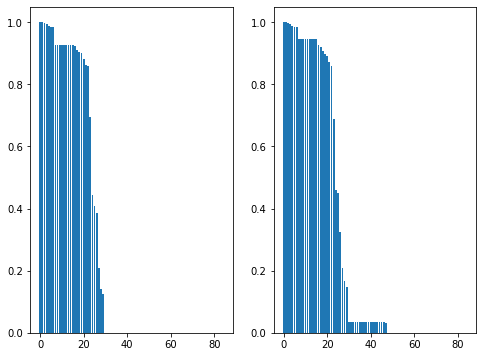

In [36]:
# plot the distribution of NaN values
cols_with_nan_w1 = (final_dataframes['wave_1'].isna().sum() / len(final_dataframes['wave_1'])).sort_values(
    ascending=False)

cols_with_nan_w2 = (final_dataframes['wave_2'].isna().sum() / len(final_dataframes['wave_2'])).sort_values(
    ascending=False)

x_ticks_w1 = np.arange(len(cols_with_nan_w1))
x_ticks_w2 = np.arange(len(cols_with_nan_w2))

fig, ax = plt.subplots(ncols=2, figsize=(8, 6))
ax[0].bar(x_ticks_w1, cols_with_nan_w1)
ax[1].bar(x_ticks_w2, cols_with_nan_w2)

In [37]:
# drop the columsn whose NaN values make up > 10% of that column
more_than_10_w1 = cols_with_nan_w1[cols_with_nan_w1 > 0.1].copy()

In [38]:
# the columns we'll be dropping
print(f"We are dropping {len(more_than_10_w1)} columns.")
more_than_10_w1

We are dropping 30 columns.


HEALTH_DEVELOPMENT_DELAY       1.000000
DEFERRED_INC_AMT               0.999295
ROLL_OVER_AMT                  0.997560
TOTAL_LIFE_INSURANCE_AMT       0.993277
PLAN_INVEST_ROLL_OVER          0.987928
INVEST_ROLL_OVER               0.985976
TOTAL_PENSION_LUMP_SUMP_PAY    0.982850
HEALTH_HELP_VA                 0.927785
HEALTH_HELP_CLINIC             0.927785
HEALTH_HELP_ER                 0.927785
HEALTH_HELP_HSP                0.927785
HELATH_HELP_DR                 0.927785
HEALTH_HELP_DENTIST            0.927785
HEALTH_HELP_OTH                0.927785
HEALTH_ILLNESS_OR_INJURY       0.927785
HEALTH_PREVENTATIVE            0.927785
NO_INSUR_DENTIST               0.922671
VA_BENEFIT_PAYMENTS            0.909352
MEDICARE_D_PAY                 0.903262
NO_INSUR_DOC                   0.900822
CHILD_CARE_PAY_ASST            0.881594
HEALTH_JOB_DIFFICULTY          0.863161
HOWWELL                        0.860161
EMPLOYER_HEALTH_INSURANCE      0.694913
HEALTH_FLEX_SPENDING_ACC       0.443083


In [39]:
# we'll be dropping the same columns for both dataframes
final_dataframes['wave_1'] = final_dataframes['wave_1'].drop(columns=more_than_10_w1.index)
final_dataframes['wave_2'] = final_dataframes['wave_2'].drop(columns=more_than_10_w1.index)

In [40]:
print(f"Number of respondents left in wave 1: {len(final_dataframes['wave_1'])}")
print(f"Number of respondents left in wave 2: {len(final_dataframes['wave_2'])}")

Number of respondents left in wave 1: 55335
Number of respondents left in wave 2: 44209


In [41]:
print(f"Number of missing values in wave 1: {final_dataframes['wave_1'].isna().sum().sum()}")
print(f"Number of missing values in wave 2: {final_dataframes['wave_2'].isna().sum().sum()}")

Number of missing values in wave 1: 0
Number of missing values in wave 2: 28466


In [42]:
print(f"Number of respondents with missing target variable: {final_dataframes['wave_2']['OPM_RATIO'].isna().sum()}")

Number of respondents with missing target variable: 1402


In [43]:
# the columns that we'll be using
final_dataframes['wave_1'].columns.tolist()

['UNIQUE_ID',
 'SSUID',
 'PNUM',
 'OPMTHRESH',
 'OPM_RATIO',
 'LIVING_QUARTERS_TYPE',
 'LIVING_OWNERSHIP',
 'SNAP_ASSISTANCE',
 'WIC_ASSISTANCE',
 'MEDICARE_ASSISTANCE',
 'MEDICAID_ASSISTANCE',
 'HEALTHDISAB',
 'DAYS_SICK',
 'HOSPITAL_NIGHTS',
 'PRESCRIPTION_MEDS',
 'VISIT_DENTIST_NUM',
 'VISIT_DOCTOR_NUM',
 'HEALTH_INSURANCE_PREMIUMS',
 'HEALTH_OVER_THE_COUNTER_PRODUCTS_PAY',
 'HEALTH_MEDICAL_CARE_PAY',
 'HEALTH_HEARING',
 'HEALTH_SEEING',
 'HEALTH_COGNITIVE',
 'HEALTH_AMBULATORY',
 'HEALTH_SELF_CARE',
 'HEALTH_ERRANDS_DIFFICULTY',
 'HEALTH_CORE_DISABILITY',
 'HEALTH_SUPPLEMENTAL_DISABILITY',
 'AGE',
 'GENDER',
 'RACE',
 'EDUCATION',
 'MARITAL_STATUS',
 'CITIZENSHIP_STATUS',
 'FAMILY_SIZE_AVG',
 'ORIGIN',
 'HOUSEHOLD_INC',
 'RECEIVED_WORK_COMP',
 'TANF_ASSISTANCE',
 'UNEMPLOYMENT_COMP',
 'SEVERANCE_PAY_PENSION',
 'FOSTER_CHILD_CARE_AMT',
 'CHILD_SUPPORT_AMT',
 'ALIMONY_AMT',
 'INCOME_FROM_ASSISTANCE',
 'INCOME',
 'SAVINGS_INV_AMOUNT',
 'UNEMPLOYMENT_COMP_AMOUNT',
 'VA_BENEFITS_AMOUNT'

# Drop individual with missing target variables

In [44]:
# sort the dataframes based on their `UNIQUE_ID`
final_dataframes['wave_1'] = final_dataframes['wave_1'].sort_values(by='UNIQUE_ID').reset_index(drop=True)
final_dataframes['wave_2'] = final_dataframes['wave_2'].sort_values(by='UNIQUE_ID').reset_index(drop=True)

In [45]:
respondents_to_keep = final_dataframes['wave_2'][~final_dataframes['wave_2']['OPM_RATIO'].isna()]['UNIQUE_ID']

In [46]:
# drop the individual with missing target variables (i.e., `OPM_RATIO` in wave 2) usig their `UNIQUE_ID`
final_dataframes['wave_1'] = final_dataframes['wave_1'][final_dataframes['wave_1']['UNIQUE_ID'].isin(
    respondents_to_keep)]
final_dataframes['wave_2'] = final_dataframes['wave_2'][final_dataframes['wave_2']['UNIQUE_ID'].isin(
    respondents_to_keep)]

In [47]:
print(f"Number of respondents left in wave 1: {len(final_dataframes['wave_1'])}")
print(f"Number of respondents left in wave 2: {len(final_dataframes['wave_2'])}")

Number of respondents left in wave 1: 39720
Number of respondents left in wave 2: 42807


In [48]:
# since we have more individual in wave 2, we'll drop the ones that are not also included in wave 1
wave_1_respondents_ids = final_dataframes['wave_1']['UNIQUE_ID'].copy()

final_dataframes['wave_2'] = final_dataframes['wave_2'][final_dataframes['wave_2']['UNIQUE_ID'].isin(
    wave_1_respondents_ids)]

In [49]:
print(f"Number of respondents left in wave 1: {len(final_dataframes['wave_1'])}")
print(f"Number of respondents left in wave 2: {len(final_dataframes['wave_2'])}")

Number of respondents left in wave 1: 39720
Number of respondents left in wave 2: 39720


In [50]:
# sort the dataframes by their `UNIQUE_ID` and reset their indices one last time
final_dataframes['wave_1'] = final_dataframes['wave_1'].sort_values(by='UNIQUE_ID').reset_index(drop=True)
final_dataframes['wave_2'] = final_dataframes['wave_2'].sort_values(by='UNIQUE_ID').reset_index(drop=True)

In [51]:
final_dataframes['wave_1']['UNIQUE_ID'].equals(final_dataframes['wave_2']['UNIQUE_ID'])

True

# Save the clean data

In [52]:
final_dataframes['wave_1'].to_csv('sipp_2014_wave_1.csv', 
                                  index=False)
final_dataframes['wave_2'].to_csv('sipp_2014_wave_2.csv', 
                                  index=False)